# Milk Production Forecast using Time Series

In [299]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [300]:
import matplotlib.pyplot as plt
%matplotlib inline

In [301]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [302]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [303]:
df.rename(columns ={'Monthly milk production: pounds per cow. Jan 62 ? Dec 75': 'Milk produced'}, inplace=True)

In [304]:
df.head()

,Month,Milk produced
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [305]:
df.tail()

,Month,Milk produced
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [306]:
df.drop(168,axis=0,inplace=True)

In [307]:
df.dtypes

Month             object
Milk produced    float64
dtype: object

In [308]:
df['Month'] = pd.to_datetime(df['Month'])

In [309]:
df.dtypes

Month            datetime64[ns]
Milk produced           float64
dtype: object

In [310]:
df.set_index('Month',inplace=True)

In [311]:
df.head()

,Milk produced
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [312]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk produced,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


## Milk Produced v/s Year

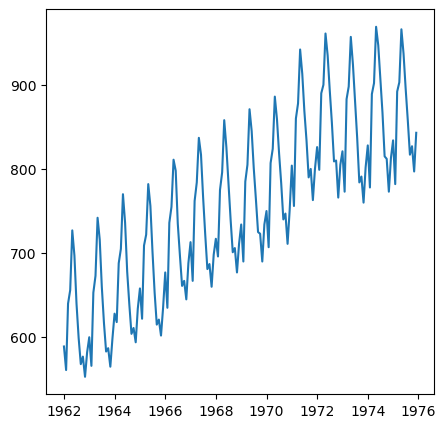

In [314]:
plt.figure(figsize=(5,5))
plt.plot(df['Milk produced']) ### lineplot
plt.show()

## ACF and PACF Plots

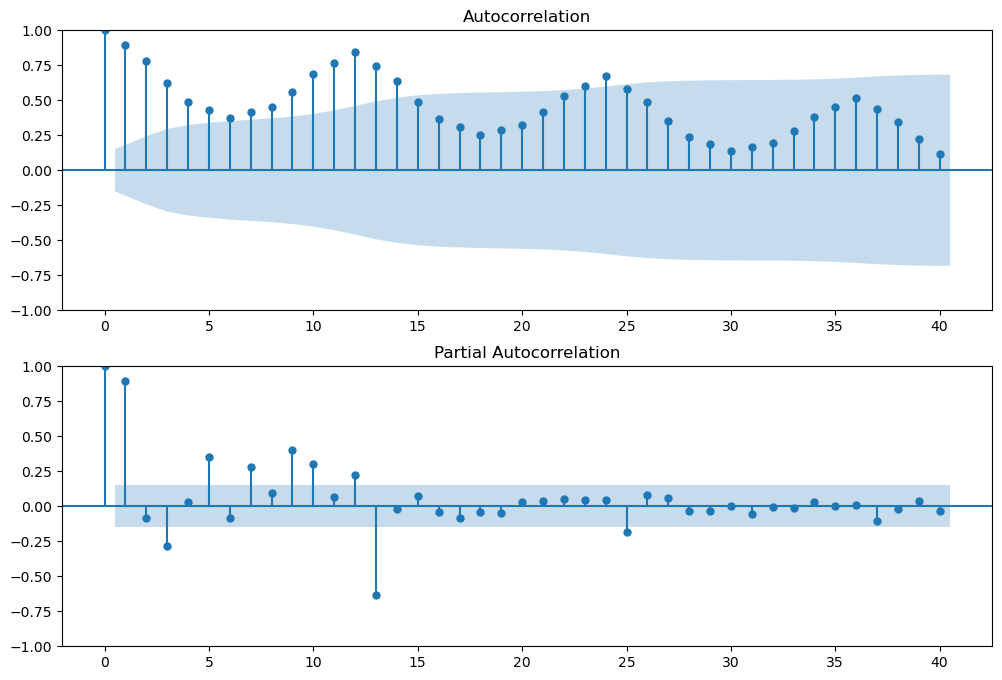

In [316]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Milk produced'], lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Milk produced'], lags = 40, ax = ax2)
plt.show()

## Seasonal Decompose

In [318]:
#Seasonal decompose identifies a trend, seasonality and residuals in a time series and plots them
from statsmodels.tsa.seasonal import seasonal_decompose #### classical decomposition

In [320]:
decomposition = seasonal_decompose(df['Milk produced'])

<Figure size 640x480 with 0 Axes>

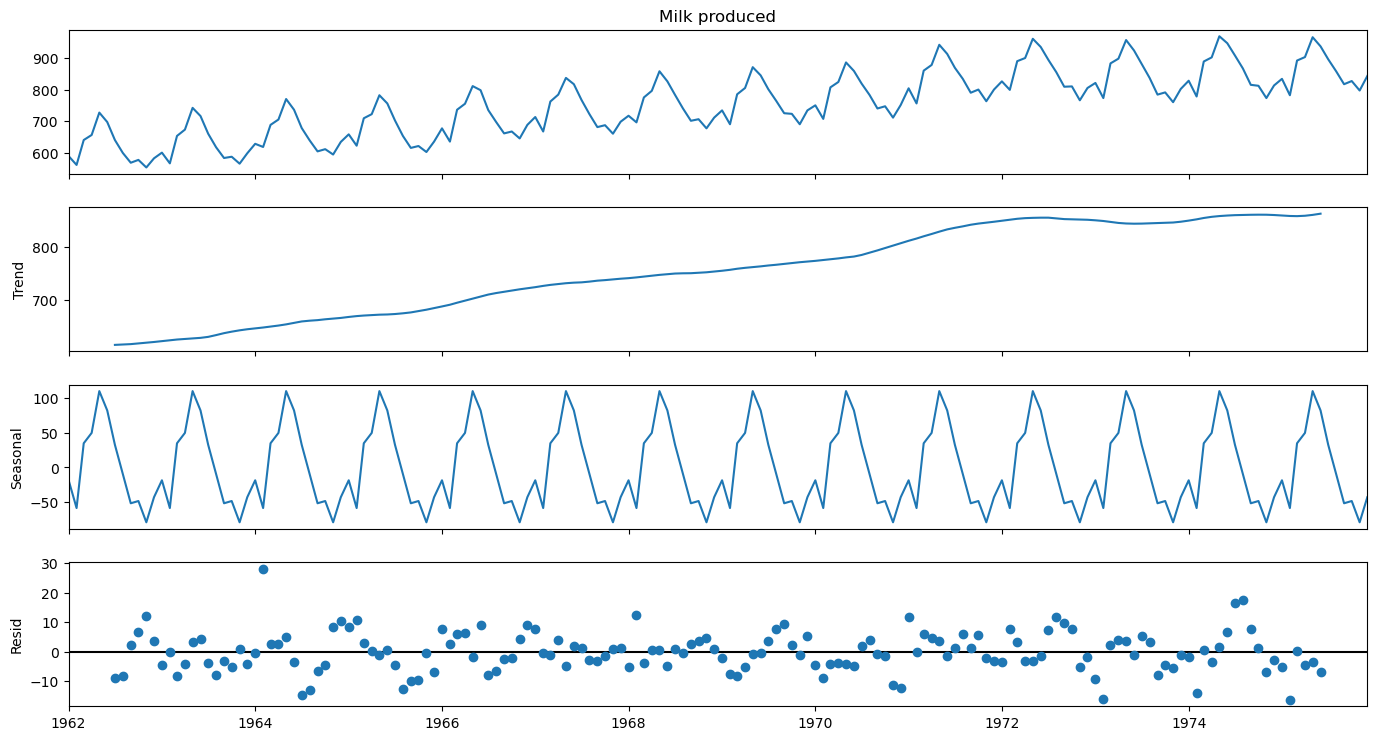

In [321]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

## Augmented Dickey-Fuller Test

In [323]:
from statsmodels.tsa.stattools import adfuller

In [324]:
#The adf_check function takes a Time Series and tells us if the Time Series is stationary or not
# Null Hypothesis is that the TS is Non-Stationary
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series) #Hypothesis testing
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] < 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [325]:
result = adf_check(df['Milk produced']) ## Expecting -  Non stationary

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221228
p-value : 0.6274267086030347
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


In [326]:
#### Fit SARIMA
#### p, d, q, P, D, Q
#### p,q,P,Q are hyperparameters ### we will tune this
#### d, D are differencing to convert non stationary timeseries to a stationary time series

In [327]:
df['Milk produced'] #YT

Month
1962-01-01    589.0
1962-02-01    561.0
1962-03-01    640.0
1962-04-01    656.0
1962-05-01    727.0
              ...  
1975-08-01    858.0
1975-09-01    817.0
1975-10-01    827.0
1975-11-01    797.0
1975-12-01    843.0
Name: Milk produced, Length: 168, dtype: float64

In [328]:
df['Milk produced'].shift(1) #YT-1

Month
1962-01-01      NaN
1962-02-01    589.0
1962-03-01    561.0
1962-04-01    640.0
1962-05-01    656.0
              ...  
1975-08-01    896.0
1975-09-01    858.0
1975-10-01    817.0
1975-11-01    827.0
1975-12-01    797.0
Name: Milk produced, Length: 168, dtype: float64

In [329]:
df['Milk produced'].shift(12).head(20) ### YT-12

Month
1962-01-01      NaN
1962-02-01      NaN
1962-03-01      NaN
1962-04-01      NaN
1962-05-01      NaN
1962-06-01      NaN
1962-07-01      NaN
1962-08-01      NaN
1962-09-01      NaN
1962-10-01      NaN
1962-11-01      NaN
1962-12-01      NaN
1963-01-01    589.0
1963-02-01    561.0
1963-03-01    640.0
1963-04-01    656.0
1963-05-01    727.0
1963-06-01    697.0
1963-07-01    640.0
1963-08-01    599.0
Name: Milk produced, dtype: float64

In [330]:
#### First order normal differencing
#1. Remove Seasonality (1)
#2. Remove trend from the output of step1 (1)
#3. Plot and check the output of step2

seasonality_removed = df['Milk produced'] - df['Milk produced'].shift(12) #### First order seasonal differencing (Yt)-(Yt-12)

trend_seasonality_removed = seasonality_removed - seasonality_removed.shift(1) #### first order normal differencing

trend_seasonality_removed = trend_seasonality_removed.dropna()

trend_seasonality_removed.plot()

#If we see some more seasonality after the abpve execution let's say, then we perform seasonal differencing again
#Then D=2
#If we see some more trend, then we perform normal differencing again
#Then d=2

<Axes: xlabel='Month'>

In [331]:
print(adf_check(trend_seasonality_removed)) ### first order seasonal differencing and first order trend differencing

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.0380022749219915
p-value : 1.865423431878764e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
None


In [332]:
#d=1, D=1, #p,P,q,Q --> stationary

In [333]:
#q=1
# Q - Seasonal lags

## ACF and PACF Plots after first order seasonal differencing and first order trend differencing

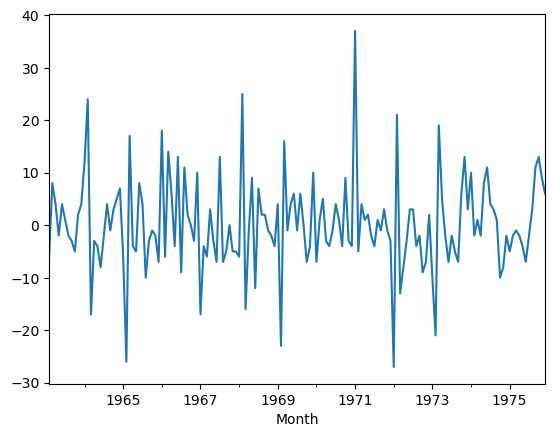

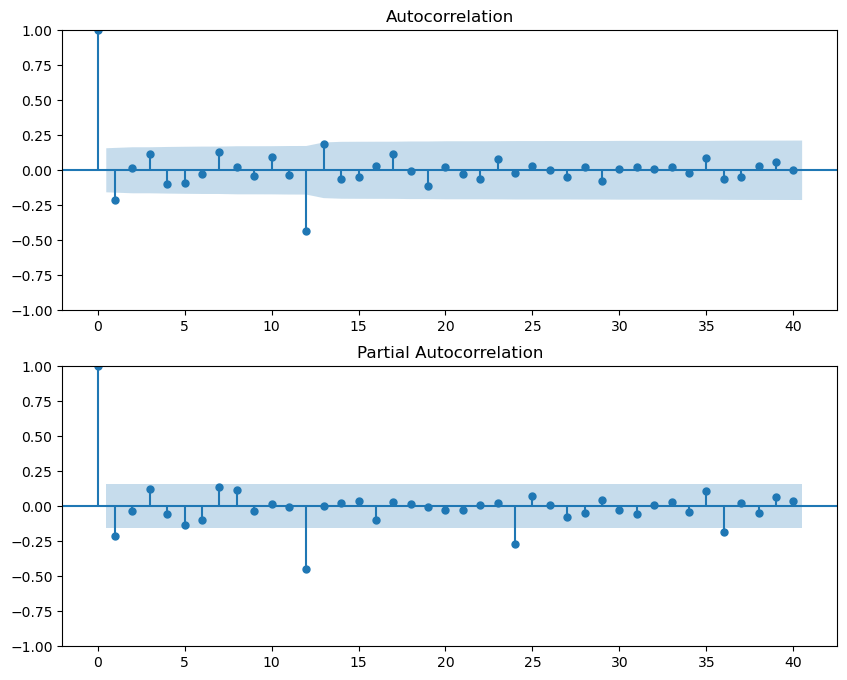

In [335]:
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trend_seasonality_removed,lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trend_seasonality_removed,lags = 40, ax = ax2)
plt.show()

In [336]:
# ACF gives us q and Q => Here q=1 and Q=1
# PACF gives us p and P => Here p=1 and P=3(12,24,36)
# Also, we have d=1 and D=1
# We are seeing no autocorrelation as expected.

In [337]:
# So the equation will be

# B0+B1y(t-1)  => p
#          +
# theta0+theta1Eps(t-1)  => q
#          +
# Eta0+Eta1y(t-12)+Eta2y(t-24)+Eta3y(t-36) => P
#          +
# Fi0+Fi1Eps(t-12) => Q

# So, model with  learn 7 parameters during the training K(covers B0,theta0,Eta0,Fi0),B1,theta1,Eta1,Et2,Eta3,Fi1

In [338]:
def rmse(series1, series2):
  error = series1-series2
  se_error = error**2
  rmse_ = np.sqrt(np.mean(se_error))
  return rmse_

In [339]:
def mape(actual, predicted):
  error = actual-predicted
  abs_error = np.absolute(error)
  percent_abs_error = (abs_error/actual)*100
  mape_ = np.mean(percent_abs_error)
  return mape_

In [340]:
#order takes p,d,q
#seasonal_order takes P,D,Q,seasonality(12 here)
model = sm.tsa.statespace.SARIMAX(df['Milk produced'],
                                  order = (1,1,1),
                                  seasonal_order = (3,1,1,12))

In [341]:
results = model.fit() ## Model training happens and it learns coefficient
#print(results.summary())
#print('\n\n')
#print('RMSE {}'.format(rmse(results.fittedvalues, df['Milk produced'])))
#print('MAPE {}'.format(mape(df['Milk produced'], results.fittedvalues)))

In [342]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Milk produced   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                -527.334
Date:                            Wed, 20 Nov 2024   AIC                           1068.669
Time:                                    19:41:37   BIC                           1089.973
Sample:                                01-01-1962   HQIC                          1077.322
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1344      0.393     -0.342      0.733      -0.905       0.636
ma.L1         -0.0716      0.391   

In [343]:
# ar.L1 -> AutoRegression with Lag1 -> B1 -> -0.1344
# ma.L1 -> Moving Average with Lag1 -> theta1 -> -0.0716
# ar.S.L12 -> AutoRegression Seasonality Lag 12 -> Eta1 -> -0.5769
# ar.S.L24 -> AutoRegression Seasonality Lag 24 -> Eta2 -> -0.3581
# ar.S.L36 -> AutoRegression Seasonality Lag 36 -> Eta3 -> -0.2854
# ma.S.L12 -> Moving Average Seasonality Lag12 -> Fi1 -> -0.0855
# sigma2 -> constant K(covers B0,theta0,Eta0,Fi0) -> 50.1729

In [344]:
results.fittedvalues #### Prediction on the data the model was trained on

Month
1962-01-01      0.000000
1962-02-01    588.995291
1962-03-01    561.001081
1962-04-01    639.998592
1962-05-01    655.999933
                 ...    
1975-08-01    856.224128
1975-09-01    808.568369
1975-10-01    819.230970
1975-11-01    788.815674
1975-12-01    835.027349
Length: 168, dtype: float64

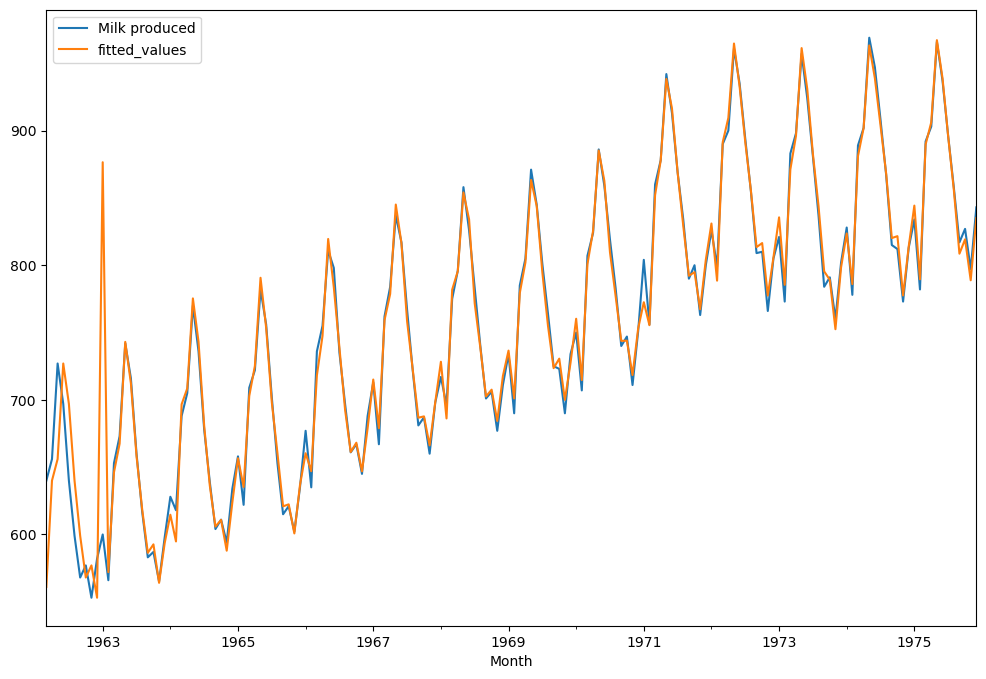

In [345]:
##### FORECAST####
df['fitted_values'] = results.fittedvalues
temp_df = df.iloc[2:, :]
temp_df[['Milk produced', 'fitted_values']].plot(figsize = (12, 8))
plt.show()

In [346]:
results.forecast(12) #### Forecast for future 12 dates

1976-01-01     865.587657
1976-02-01     822.108480
1976-03-01     926.580407
1976-04-01     938.351486
1976-05-01    1001.402914
1976-06-01     974.646193
1976-07-01     933.880110
1976-08-01     894.360239
1976-09-01     847.963620
1976-10-01     851.813177
1976-11-01     815.193861
1976-12-01     857.039553
Freq: MS, Name: predicted_mean, dtype: float64

## Hyper Paramater tuning

In [348]:
p = range(0,4) #p = [0, 1, 2, 3]
d = [1] # d = 1
q = range(0,4) # q= [0,1,2,3]

P = range(0,2) # P = [0,1]
D = [1]
Q = range(0,2) # Q = [0,1]

freq=12

In [349]:
#Generates all combinations of the given identifier values
import itertools

list(itertools.product(p, d, q))

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [350]:
import itertools
import warnings

# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,4)
q = range(0,4) ## experiment with p [0,1,2,3,4], q = [0,1,2,3,4]
d = [1]

seasonal_p = range(0,2)
seasonal_q = range(0,2)
seasonal_d = [1]
frequency=[12]

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))  ####output = [(0,1,0), (0,1,1), (0,1,2)]

# Generate all different combinations of P, D and Q triplets
seasonal_pdq = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, frequency))  ###output= [(0,1,0,12), (0,1,1,12)]


# Generate all different combinations of seasonal p, q and q triplets
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(range(0,4), range(1,3), range(0,3)))]

print('Examples of parameter combinations for Seasonal ARIMA...')

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq: #Iterating over all the values in pdq ; i is param here
    for param_seasonal in seasonal_pdq: #Iterating over all the values in PDQ ; j is param_seasonal here
        try:
            mod = sm.tsa.statespace.SARIMAX(df['Milk produced'],
                                            order=param,
                                            seasonal_order=param_seasonal)

            results = mod.fit()

            print('SARIMA{}x{}12 - MAPE:{}'.format(param, param_seasonal, mape(df['Milk produced'], results.fittedvalues)))
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - MAPE:2.0577185005942167
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - MAPE:1.9743735982754873
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - MAPE:1.976863533321987
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - MAPE:1.9728639292308001
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - MAPE:2.0550245387407027
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - MAPE:1.9613260017811307
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - MAPE:1.9724128688979141
SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - MAPE:1.957786321194153
SARIMA(0, 1, 2)x(0, 1, 0, 12)12 - MAPE:2.0537128727451
SARIMA(0, 1, 2)x(0, 1, 1, 12)12 - MAPE:1.9617957416330483
SARIMA(0, 1, 2)x(1, 1, 0, 12)12 - MAPE:1.9748425480130372
SARIMA(0, 1, 2)x(1, 1, 1, 12)12 - MAPE:1.9583488212093907
SARIMA(0, 1, 3)x(0, 1, 0, 12)12 - MAPE:2.0486466116735946
SARIMA(0, 1, 3)x(0, 1, 1, 12)12 - MAPE:1.9573979181016656
SARIMA(0, 1, 3)x(1, 1, 0, 12)12 - MAPE:1.968644332622489
SARIMA(0, 1, 3)x(1, 1, 1, 12)12 - MAPE:1.9553864824684806
SARIMA(1, 1, 0)x(0, 1

In [351]:
forecasted_values = results.forecast(12)

In [352]:
df = pd.concat([df, pd.DataFrame(forecasted_values)], axis=1)

In [353]:
df.rename(columns ={'predicted_mean': 'forecasts'}, inplace=True)

In [354]:
df

,Milk produced,fitted_values,forecasts
1962-01-01,589.0,0.000000,NaN
1962-02-01,561.0,588.995291,NaN
1962-03-01,640.0,561.001081,NaN
1962-04-01,656.0,639.998592,NaN
1962-05-01,727.0,655.999933,NaN
...,...,...,...
1976-08-01,NaN,NaN,893.425465
1976-09-01,NaN,NaN,846.403263
1976-10-01,NaN,NaN,849.910722
1976-11-01,NaN,NaN,815.877612


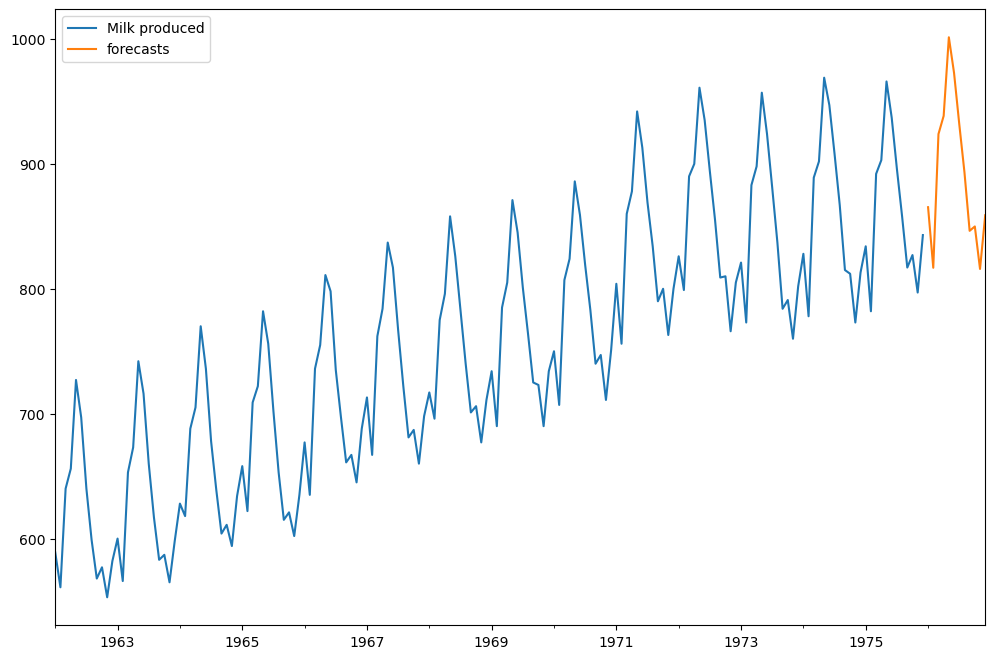

In [355]:
df[['Milk produced','forecasts']].plot(figsize = (12, 8))

plt.show()